In [1]:
library(caret)
library(keras)
library(nnet)
library(lime)
library(corrr)
library(dplyr)
library (tidyquant)
library(forcats)
library(ggplot2)

Loading required package: lattice
Loading required package: ggplot2

Attaching package: ‘dplyr’

The following object is masked from ‘package:lime’:

    explain

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union

Loading required package: lubridate

Attaching package: ‘lubridate’

The following object is masked from ‘package:base’:

    date

Loading required package: PerformanceAnalytics
Loading required package: xts
Loading required package: zoo

Attaching package: ‘zoo’

The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric


Attaching package: ‘xts’

The following objects are masked from ‘package:dplyr’:

    first, last


Attaching package: ‘PerformanceAnalytics’

The following object is masked from ‘package:graphics’:

    legend

Loading required package: quantmod
Loading required package: TTR
Version 0.4-0 included new data default

# Simulate Data

In [2]:
set.seed(1234)

#Create data set
data_set <- twoClassSim(200000,
                        intercept = -6,
                        linearVars = 8,
                        noiseVars = 8)


#Create train/tests sets
index <- createDataPartition(data_set$Class, p = .5, list=FALSE)

train_set <- data_set[index,]
test_set <- data_set[-index,]

In [3]:
#Dependent / Independent Variables
Y <-'Class'
X <-names(train_set)[!names(train_set) %in% Y]

# Keras

In [4]:
#Build Keras Model
model_keras <- keras_model_sequential()

#Set up Y vector
y_train_vec <- ifelse(train_set[,Y]  == "Class2", 1, 0)

model_keras <- model_keras %>% 
  
  # First hidden layer
  layer_dense(
    units              = 16, 
    kernel_initializer = "uniform", 
    activation         = "relu", 
    input_shape        = ncol( train_set[,X] )) %>% 
  
  # Dropout to prevent overfitting
  layer_dropout(rate = 0.1) %>%
  
  # Second hidden layer
  layer_dense(
    units              = 16, 
    kernel_initializer = "uniform", 
    activation         = "relu") %>% 
  
  # Dropout to prevent overfitting
  layer_dropout(rate = 0.1) %>%



  # Third hidden layer
  layer_dense(
    units              = 16, 
    kernel_initializer = "uniform", 
    activation         = "relu") %>% 
  
  # Dropout to prevent overfitting
  layer_dropout(rate = 0.1) %>%
  
  # Output layer
  layer_dense(
    units              = 1, 
    kernel_initializer = "uniform", 
    activation         = "sigmoid") %>% 
  
  # Compile ANN
  compile(
    optimizer = 'adam',
    loss      = 'binary_crossentropy',
    metrics   = c('accuracy')
  )

In [5]:
history <- fit(
  object           = model_keras, 
  x                = as.matrix( train_set[,X] ), 
  y                = as.matrix( y_train_vec ),
  batch_size       = 50, 
  epochs           = 50,
  validation_split = 0.30
)

In [6]:
print(history)

Trained on 70,000 samples, validated on 30,000 samples (batch_size=50, epochs=50)
Final epoch (plot to see history):
val_loss: 0.1826
 val_acc: 0.922
    loss: 0.185
     acc: 0.9213 


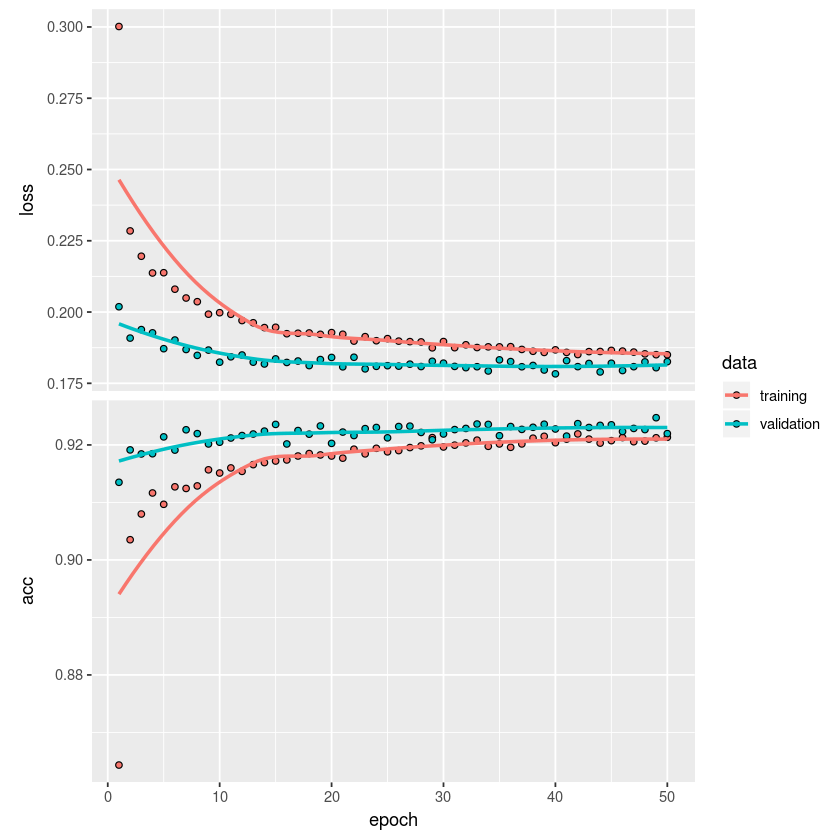

In [7]:
plot(history)

# Compare

In [8]:
require(PRROC)

Loading required package: PRROC


In [9]:
keras_prob  <- predict_proba(object = model_keras, x = as.matrix(test_set[,X])) %>%
    as.vector()

In [10]:
class2 <- keras_prob[test_set[,Y] == 'Class2']
class1 <- keras_prob[test_set[,Y] == 'Class1']

#Curve
pr <- pr.curve(scores.class0 = class2, scores.class1 = class1)
pr

roc <- roc.curve(scores.class0 = class2, scores.class1 = class1)
roc

mean((keras_prob > .5 & test_set[,Y] == 'Class2') | (keras_prob <= .5 & test_set[,Y] != 'Class2') )


  Precision-recall curve

    Area under curve (Integral):
     0.9716458 

    Area under curve (Davis & Goadrich):
     0.9716458 

    Curve not computed ( can be done by using curve=TRUE )


  ROC curve

    Area under curve:
     0.9797451 

    Curve not computed ( can be done by using curve=TRUE )

[1] 0.92298

# Lime

In [11]:
class(model_keras)
#No
model_type.keras.models.Sequential <- function(x, ...) {
  "classification"}


#Good
#https://github.com/thomasp85/lime/issues/139
model_type.keras.engine.sequential.Sequential <- function(x, ...) {
  "classification"
}


predict_model.keras.engine.sequential.Sequential  <- function (x, newdata, type, ...) {
  pred <- predict_proba (object = x, x = as.matrix(newdata))
  data.frame (Positive = pred, Negative = 1 - pred) }

[1] "keras.engine.sequential.Sequential" "keras.engine.training.Model"       
[3] "keras.engine.network.Network"       "keras.engine.base_layer.Layer"     
[5] "python.builtin.object"

In [12]:
explainer <- lime::lime (
  x              = train_set[,X], 
  model          = model_keras, 
  bin_continuous = FALSE)

In [13]:
system.time (
  explanation <- lime::explain (
    test_set[1:6,X], # Just to show first 10 cases
    explainer    = explainer, 
    n_labels     = 1, # explaining a `single class`(Polarity)
    n_features   = 5, # returns top four features critical to each case
    kernel_width = 0.5) ) # allows us to increase model_r2 value by shrinking the localized evaluation.

   user  system elapsed 
  2.652   0.000   2.153 

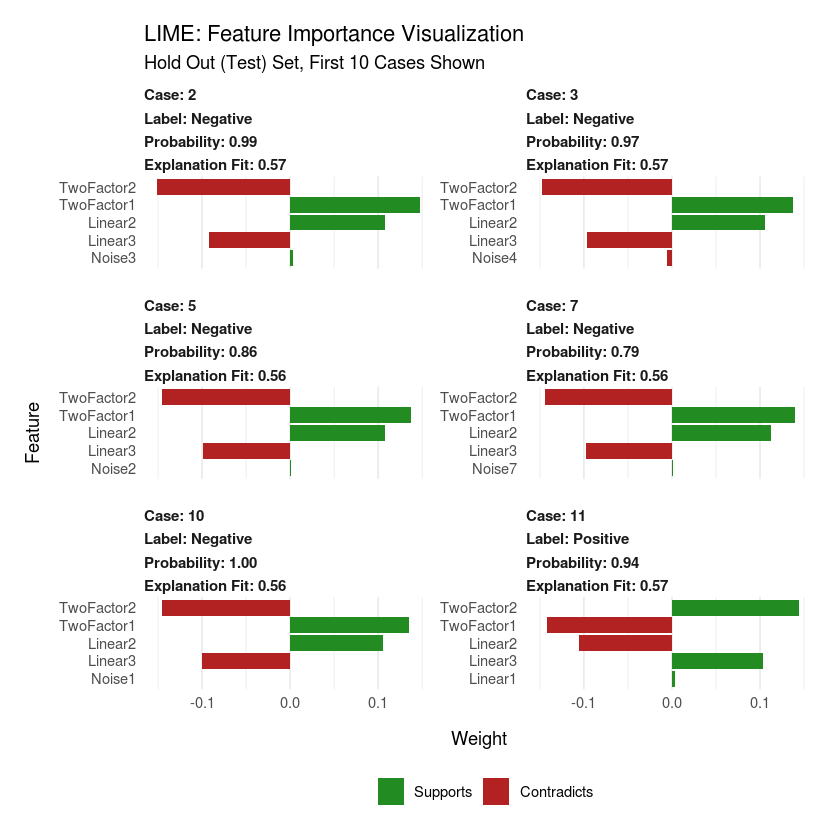

In [14]:
plot_features (explanation) +
  labs (title = "LIME: Feature Importance Visualization",
        subtitle = "Hold Out (Test) Set, First 10 Cases Shown")

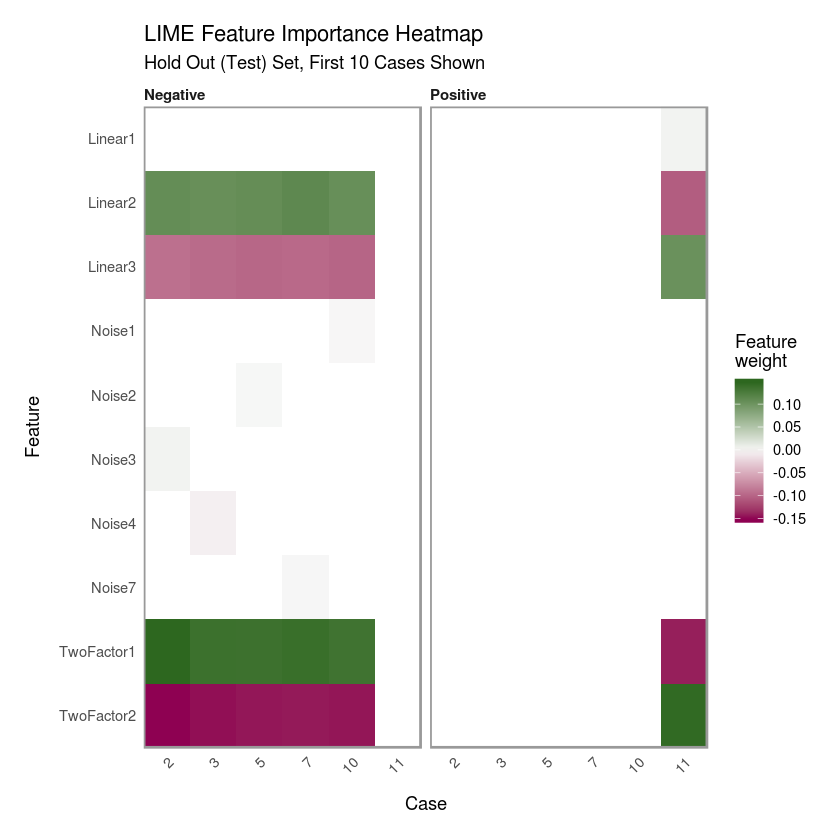

In [15]:
plot_explanations (explanation) +
  labs (title = "LIME Feature Importance Heatmap",
        subtitle = "Hold Out (Test) Set, First 10 Cases Shown")

In [16]:
corrr_analysis <- train_set[,X] %>%
    mutate (Class = as.numeric(train_set[,Y])) %>%
    correlate () %>%
    focus (Class) %>%
    rename (feature = rowname) %>%
    arrange (abs(Class)) %>%
    mutate (feature = as.factor(feature))


Correlation method: 'pearson'
Missing treated using: 'pairwise.complete.obs'



In [17]:
library(tidyverse)
as.data.frame(corrr_analysis)

feature,Class
Noise4,-0.0003595049
Noise1,0.0017107083
Linear1,-0.0027201119
Noise5,-0.0028002163
Noise2,0.0028998034
Noise8,0.0029489121
Noise3,-0.0032366534
Noise6,0.0041510148
Noise7,-0.0091339914
Nonlinear3,0.0369156112


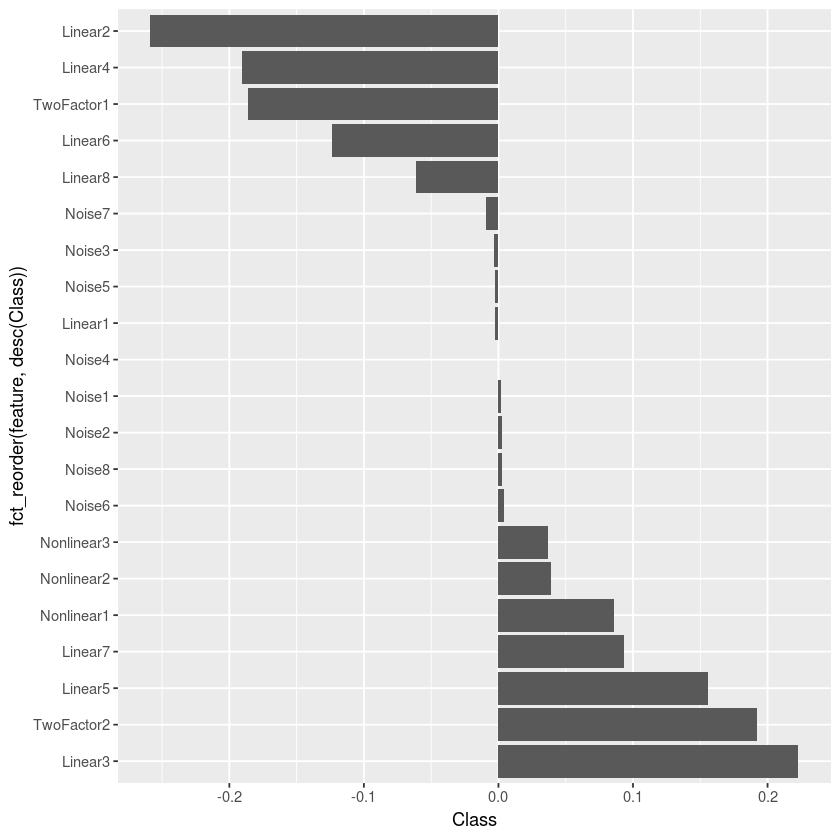

In [20]:
DF <- data.frame(feature = corrr_analysis$feature, Class = corrr_analysis$Class) %>% 
    mutate(feature = fct_reorder(feature, desc(Class)) )

ggplot(data =  DF, aes(x = fct_reorder(feature, desc(Class)), y = Class)) +
  geom_bar(stat="identity") + coord_flip()

In [ ]:
fct_reorder(feature, desc(Class))